# Exponent Comparisons

This notebook compares methods that directly estimate aperiodic exponents.  

Compared methods:
- spectral parameterization
- IRASA

ToDo:
- This notebook is incomplete, and will be fleshed out when the full IRASA explorations are integrated, and can be compared directly to specparam here

In [1]:
import numpy as np
from scipy.stats import ttest_rel

from neurodsp.sim import sim_powerlaw, sim_combined, sim_synaptic_current, sim_peak_oscillation
from neurodsp.utils import set_random_seed

from bootstrap import bootstrap_corr

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_comparisons
from apm.plts import plot_dots
from apm.plts.errors import plot_violin_errors
from apm.methods import irasa, specparam
from apm.methods.settings import IRASA_PARAMS
from apm.analysis.error import calculate_errors
from apm.sim.settings import FS, SIM_PARAMS_AP, SIM_PARAMS_COMB, SIM_PARAMS_KNEE, SIM_PARAMS_PEAK
from apm.sim.sim import sim_combined_peak
from apm.sim.params import sampler
from apm.utils import format_corr

/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/plts/data.py:7: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Set number of simulations to run
N_SIMS = 1000

In [5]:
# Define measure settings
f_range = [1, 50]
specparam_params = {'min_peak_height' : 0.05, 'fs' : FS, 'f_range' : f_range}

In [6]:
# Define run settings
RETURN_SIM_PARAMS = True

In [7]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APMDB().figs_path / '21_exp_exp_comp'

In [8]:
# Set the random seed
set_random_seed(111)

### Collect Methods

In [9]:
# Define measures to apply
measures = {specparam : specparam_params,
            irasa : IRASA_PARAMS}

## Simulations - Samples Across Aperiodic Signals 

In [10]:
# Define ranges to sample parameters from
samplers_ap = {'update_exp' : sampler(np.arange(-2.5, 0, 0.1))}

In [11]:
# Run simulations, comparing SpecParam & IRASA, sampling across aperiodic exponents
results_ap, sim_params_ap = run_comparisons(\
    sim_powerlaw, SIM_PARAMS_AP, measures, samplers_ap, N_SIMS, RETURN_SIM_PARAMS)

In [12]:
# Get the simulated exponent values
sim_exps_ap = -sim_params_ap.exponent.values

In [13]:
# Calculate errors of each method, as compared to ground truth simulations
errors_ap = calculate_errors(results_ap, sim_exps_ap)

In [14]:
# Check the errors per method
for method in errors_ap.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.mean(errors_ap[method])))

specparam 	0.0582
irasa     	0.0230


In [15]:
# Check the statistical difference between measure errors
ttest_rel(errors_ap['specparam'], errors_ap['irasa'])

TtestResult(statistic=25.428185202155927, pvalue=2.158668645537156e-110, df=999)

### Visualize

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


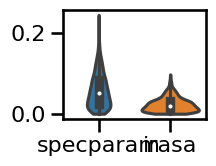

In [16]:
# Plot the errors 
plot_violin_errors(errors_ap, figsize=(2.5, 2))

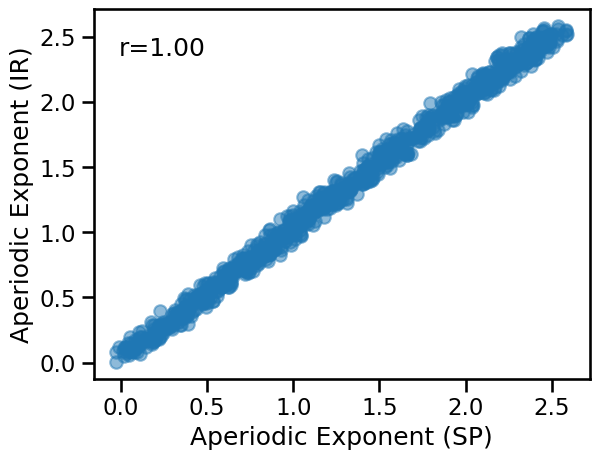

In [17]:
# Plot the comparison between specparam and IRASA
plot_dots(results_ap['specparam'], results_ap['irasa'], alpha=0.50, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='spec_irasa_exp' + EXT, file_path=FIGPATH)

In [18]:
# Check correlations
corrs_ap = bootstrap_corr(results_ap['specparam'], results_ap['irasa'])
print('  SP & IR:  ', format_corr(*corrs_ap))

  SP & IR:   r=+0.997  CI[+0.996, +0.997],  p=0.000


## Simulations - Samples Across Combined Signals 

In [19]:
# Define ranges to sample parameters from
samplers_comb = {'update_comb_exp' : sampler(np.arange(-2.5, 0, 0.1)),
                 'update_pow' : sampler(np.arange(0, 1, 0.1)),
                 'update_freq' : sampler(np.arange(5, 35, 1))}

In [20]:
# Run simulations, comparing SpecParam & IRASA, sampling across combined signal parameters
results_comb, sim_params_comb = run_comparisons(\
    sim_combined, SIM_PARAMS_COMB, measures, samplers_comb, N_SIMS, RETURN_SIM_PARAMS)

In [21]:
# Get the simulated exponent values
sim_exps_comb = -sim_params_comb.exponent.values

In [22]:
# Calculate errors of each method, as compared to ground truth simulations
errors_comb = calculate_errors(results_comb, sim_exps_comb)

In [23]:
# Check the errors per method
for method in errors_comb.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.mean(errors_comb[method])))

specparam 	0.0397
irasa     	0.0241


In [24]:
# Check the statistical difference between measure errors
ttest_rel(errors_comb['specparam'], errors_comb['irasa'])

TtestResult(statistic=14.779107248168259, pvalue=7.55554752797139e-45, df=999)

### Visualize

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


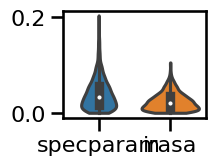

In [25]:
# Plot the errors 
plot_violin_errors(errors_comb, figsize=(2.5, 2))

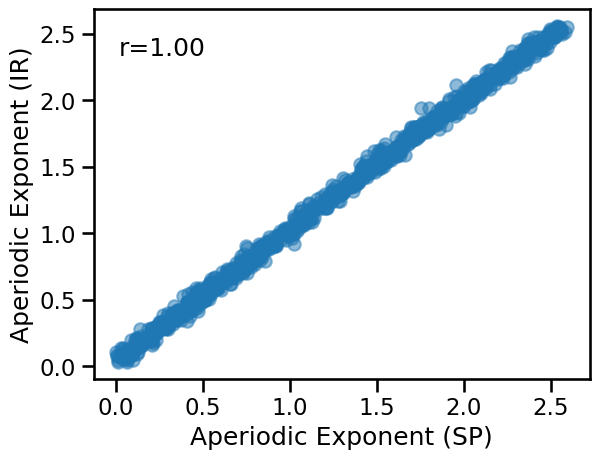

In [26]:
# Plot the comparison between specparam and IRASA
plot_dots(results_comb['specparam'], results_comb['irasa'], alpha=0.50, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='spec_irasa_comb' + EXT, file_path=FIGPATH)

In [27]:
# Check correlations
corrs_comb = bootstrap_corr(results_comb['specparam'], results_comb['irasa'])
print('  SP & IR:  ', format_corr(*corrs_comb))

  SP & IR:   r=+0.998  CI[+0.998, +0.999],  p=0.000


## Simulations - Samples Across Knee Signals 

ToDo: setup to run with knee fitting

In [33]:
# # Define ranges to sample parameters from
# samplers_knee = {'update_knee' : sampler(np.array([0.002, 0.005, 0.015, 0.040, 0.070]))}

In [34]:
# # Run simulations, comparing SpecParam & IRASA, sampling across timescale / knee values
# results_knee, sim_params_knee = run_comparisons(\
#     sim_synaptic_current, SIM_PARAMS_KNEE, measures, samplers_knee, N_SIMS, RETURN_SIM_PARAMS)

In [35]:
# # Get the simualated exponent values
# sim_exps_knee = -sim_params_knee.exponent.values

In [36]:
# # Calculate errors of each method, as compared to ground truth simulations
# errors_knee = calculate_errors(results_knee, sim_exps_knee)

In [37]:
# # Check the errors per method
# for method in errors_knee.keys():
#     print('{:10s}\t{:1.4f}'.format(method, np.mean(errors_knee[method])))

In [38]:
# # Check the statistical difference between measure errors
# ttest_rel(errors_knee['specparam'], errors_knee['irasa'])

### Visualize

In [39]:
# # Plot the errors 
# plot_violin_errors(errors_knee, figsize=(3, 2))

In [40]:
# # Plot the comparison between specparam and IRASA
# plot_dots(results_knee['specparam'], results_knee['irasa'], alpha=0.50, tposition='tl',
#           xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
#           save_fig=SAVE_FIG, file_name='spec_irasa_knee' + EXT, file_path=FIGPATH)

In [41]:
# # Check correlations
# corrs_knee = bootstrap_corr(results_bw['specparam'], results_bw['irasa'])
# print('  SP & IR:  ', format_corr(*corrs_knee))

## Simulations - Samples Across Peak Signals 

ToDo: 
- setup to run with pre-created simulations
- setup to sweep across different exponent values as well as different bandwidths

In [42]:
N_SIMS = 100

In [43]:
# Define ranges to sample parameters from
samplers_bw = {'update_peak_bw' : sampler(np.arange(0.25, 2.0, 0.25))}

In [44]:
# Run simulations, comparing SpecParam & IRASA, sampling across timescale / knee values
results_bw, sim_params_bw = run_comparisons(\
    sim_combined_peak, SIM_PARAMS_PEAK, measures, samplers_bw, N_SIMS, RETURN_SIM_PARAMS)

In [45]:
# Get the simulated exponent values
sim_exps_bw = -sim_params_bw.exponent.values

In [46]:
# Calculate errors of each method, as compared to ground truth simulations
errors_bw = calculate_errors(results_bw, sim_exps_bw)

In [47]:
# Check the errors per method
for method in errors_bw.keys():
    print('{:10s}\t{:1.4f}'.format(method, np.mean(errors_bw[method])))

specparam 	0.0568
irasa     	0.0973


In [48]:
# Check the statistical difference between measure errors
ttest_rel(errors_bw['specparam'], errors_bw['irasa'])

TtestResult(statistic=-5.214256244116513, pvalue=1.01237660638604e-06, df=99)

### Visualize

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


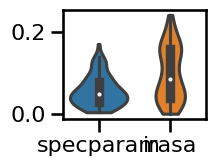

In [49]:
# Plot the errors 
plot_violin_errors(errors_bw, figsize=(2.5, 2))

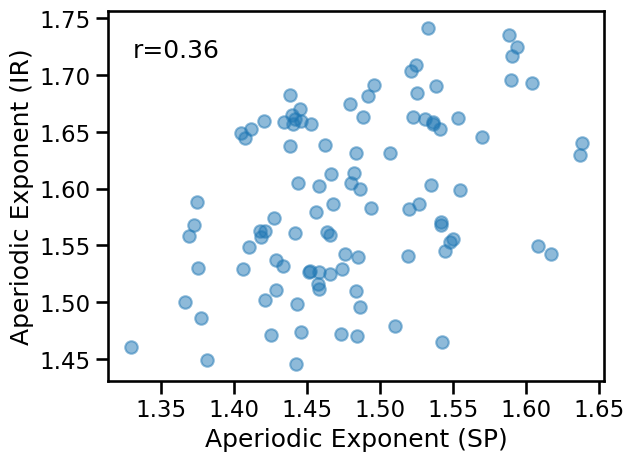

In [50]:
# Plot the comparison between specparam and IRASA
plot_dots(results_bw['specparam'], results_bw['irasa'], alpha=0.50, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='spec_irasa_bw' + EXT, file_path=FIGPATH)

In [51]:
# Check correlations
corrs_bw = bootstrap_corr(results_bw['specparam'], results_bw['irasa'])
print('  SP & IR:  ', format_corr(*corrs_bw))

  SP & IR:   r=+0.359  CI[+0.173, +0.520],  p=0.000


## Conclusions

Comparing between these methods, overall we can see that:
- In simple cases (powerlaw + oscillations), specparam and IRASA perform very similarly